#Подгружаем библиотеки и данные

In [2]:

import numpy as np
from scipy.stats import multivariate_normal as mvn
import copy
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import PIL
import torch.nn.functional as F
import torch 
import torchvision.transforms as T 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

train = pd.read_csv('train.csv')

train_not_empl=train.drop(columns=['Name', 'Cabin', 'PassengerId', 'Ticket'])
train_empl=train.drop(columns=['Name', 'Cabin', 'PassengerId', 'Ticket'],inplace=True)

train['Age'].fillna(np.mean(train['Age']), inplace=True)
train['Embarked'].fillna(('S'), inplace=True)


display(train)

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

#for col in ['Sex', 'Pclass', 'SibSp', 'Embarked']:
for col in ['Sex']:
    train_encoded = pd.DataFrame(encoder.fit_transform(train[[col]]))
    train_encoded.columns = encoder.get_feature_names([col])
    train.drop([col], axis=1, inplace=True)
    train = pd.concat([train, train_encoded], axis=1)

train = train.drop(columns=['Pclass', 'SibSp', 'Embarked'])

display(train)

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn import metrics
#X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['Survived']), train['Survived'], test_size=0.33, shuffle=False)     
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['Survived']), train['Survived'], test_size=0.33, shuffle=False)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S
887,1,1,female,19.000000,0,0,30.0000,S
888,0,3,female,29.699118,1,2,23.4500,S
889,1,1,male,26.000000,0,0,30.0000,C


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Survived,Age,Parch,Fare,Sex_female,Sex_male
0,0,22.000000,0,7.2500,0.0,1.0
1,1,38.000000,0,71.2833,1.0,0.0
2,1,26.000000,0,7.9250,1.0,0.0
3,1,35.000000,0,53.1000,1.0,0.0
4,0,35.000000,0,8.0500,0.0,1.0
...,...,...,...,...,...,...
886,0,27.000000,0,13.0000,0.0,1.0
887,1,19.000000,0,30.0000,1.0,0.0
888,0,29.699118,2,23.4500,1.0,0.0
889,1,26.000000,0,30.0000,0.0,1.0


# Реализуем обычную линейную нейронку под титаник


In [3]:
class TitanNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(TitanNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(5, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 12)
        self.activ3 = torch.nn.Sigmoid()
        self.fc4 = torch.nn.Linear(12, 6)
        self.activ4 = torch.nn.Sigmoid()
        self.fc5 = torch.nn.Linear(6, 5)
        self.activ5 = torch.nn.Sigmoid()
        self.fc6 = torch.nn.Linear(5, 2)
        
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        x = self.activ3(x)
        x = self.fc4(x)
        x = self.activ4(x)
        x = self.fc5(x)
        x = self.activ5(x)
        x = self.fc6(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
titan_net = TitanNet(10)


In [4]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(titan_net.parameters(), 
                             lr=1.0e-3)
np.random.permutation(10)

array([8, 9, 7, 2, 1, 5, 0, 4, 3, 6])

In [5]:
X_train=torch.tensor(X_train.to_numpy().astype(np.float32))
y_train=torch.tensor(y_train.to_numpy().astype(np.uint8))
X_test=torch.tensor(X_test.to_numpy().astype(np.float32))
y_test=torch.tensor(y_test.to_numpy().astype(np.uint8))

In [6]:
batch_size = 50

test_accuracy_history = []
test_loss_history = []
for epoch in range(2000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = titan_net.forward(x_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
    test_preds = titan_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
print(accuracy)
    

tensor(0.8000)


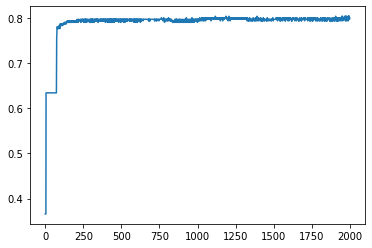

In [7]:
plt.plot(test_accuracy_history)

In [8]:
X_test_to_sb=pd.read_csv('test.csv')
X_test_to_sb['Age'].fillna(np.mean(X_test_to_sb['Age']), inplace=True)
X_test_to_sb['Embarked'].fillna(('S'), inplace=True)
PassengerId_preds=X_test_to_sb['PassengerId']
X_test_to_sb = X_test_to_sb.drop(columns=['Pclass', 'SibSp', 'Embarked','Ticket','Name','Cabin','PassengerId'])

for col in ['Sex']:
    X_test_to_sb_encoded = pd.DataFrame(encoder.fit_transform(X_test_to_sb[[col]]))
    X_test_to_sb_encoded.columns = encoder.get_feature_names([col])
    X_test_to_sb.drop([col], axis=1, inplace=True)
    X_test_to_sb = pd.concat([X_test_to_sb, X_test_to_sb_encoded], axis=1)
X_test_to_sb=torch.tensor(X_test_to_sb.to_numpy().astype(np.float32))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
X_test_to_sb

tensor([[34.5000,  0.0000,  7.8292,  0.0000,  1.0000],
        [47.0000,  0.0000,  7.0000,  1.0000,  0.0000],
        [62.0000,  0.0000,  9.6875,  0.0000,  1.0000],
        ...,
        [38.5000,  0.0000,  7.2500,  0.0000,  1.0000],
        [30.2726,  0.0000,  8.0500,  0.0000,  1.0000],
        [30.2726,  1.0000, 22.3583,  0.0000,  1.0000]])

In [10]:
out_probs = titan_net(X_test_to_sb).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)

In [11]:
submit = pd.DataFrame({'PassengerId': PassengerId_preds, 'Survived': out_classes })

In [12]:
submit.to_csv("submission.csv", index=False)